# Topic Modeling using Clustering Techniques

- This process aims to produce topics from previous data prepared in pre-processing steps
- Input is df_clean_2001_pickled.pkl.gz pickled panda dataframe, narrowed down to 2001 for ease of processing and to focus on time frame of interest
    
    *note: same data processing and analysis flow can be applied to other time frame*
- Pretrained transformer models will be used to encode cleaned_email_body into embedding vector
- embedding's dimension is then reduced to make clustering more efficient and possible
- Hierarchical density based clustering (HDBSCAN) is then performed to group individual emails into topics
- Number of Topics are reduced by cutting the number of clusters produced by initial clustering process
- K-means is also tried and explored to see if a centroid based on k=1000 produces meaningful topics

Output: df_clean_2001_clustered_pick.pkl.gz

- Dataframe :
    - subject date	
    - date_short
    - message_id	
    - from_addr	
    - person_box	
    - sub_mailbox	
    - sub_mailbox2	
    - email_body

    ADDED Fields:
    - embedding_roberta	
    - embedding_roberta_reduced
    - hdbscan_clusters_roberta
    - hdbscan_clusters_roberta_prob
    - reduced_labels_dbscan_cut
    - reduced_labels_scipy_cut

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from itables import show


from sklearn import decomposition, preprocessing
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS, TSNE
from sklearn.ensemble import IsolationForest

from sentence_transformers import SentenceTransformer

## Loading Cleaned Dataset

In [ ]:
df_clean_2001_pick = pd.read_pickle('..\data\df_clean_2001_clustered_pick.pkl.gz', compression='gzip')
df_clean_2001_pick.head(2)

### Dedupe by cleaned_email_body
1. To avoid getting cluster formation from the same email content
2. Dedupe should have been done before roberta encoding to save on process time


In [ ]:

# Deduplicate based on the 'ID' column, keeping the first occurrence
df_clean_2001_pick_dedupe = df_clean_2001_pick[['cleaned_email_body']].drop_duplicates(subset=['cleaned_email_body'], keep='first')
df_clean_2001_pick_dedupe.reset_index(drop=True, inplace=True)

# Find matching rows based on 'ID'
matching_rows = pd.merge(df_clean_2001_pick, df_clean_2001_pick_dedupe, on='cleaned_email_body', how='inner')
print(matching_rows.shape)


## Transforming Cleaned Email Body into vectors

### Deciding on Transformer Model to use

- Inspect email body, and ascertain input token size based on word count distribution
- If there are substantial emails with words longer than 128 words, will take a decision on based on what model to use


Observation:

Majority of the emails are short however there is a substantial emails longer than 128 words. If we are using all-MiniLM-L12-v2, input will be trancated to 128 and may not be powerful enough to capture semantic meaning if we base only on the first chunk of email

Options:

1. Use **all-roberta-large-v1**, will also be truncating to first 128 tokens however will be a more powerful model that can offer better embedding quality. Processing speed will suffer
2. Use even larger modle like **BigBird or LongFormer** that can handle larger input text however processing time will further suffer
3. Chunk emails into smaller paragraphs before encoding, however there will be an extra data splitting and re-integration step that will complicate analysis

Decision:

We used **all-roberta-large-v1** as a happy medium option for less data splitting, acceptable semantic accuracy and acceptable processing time.



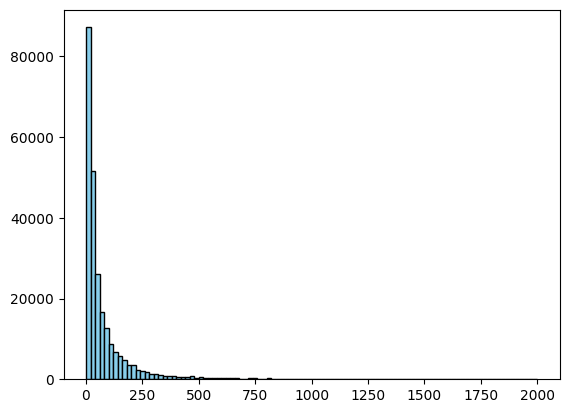

In [ ]:


bod_1 = df_clean_2001_pick_dedupe.cleaned_email_body.to_list()

# Split each string by whitespace and calculate the length of the resulting list
word_counts = df_clean_2001_pick_dedupe.cleaned_email_body.str.split().str.len()

# Create the histogram
mask = word_counts < 2000


plt.hist(word_counts[mask], bins=100, color='skyblue', edgecolor='black')

# Show the plot
plt.show()

## Encoding Cleaned Email Body to embedding vectors

- This is calling a pre-trained transformer model to encode cleaned texts to embeddings that we can perform clustering on

In [ ]:
model_roberta = SentenceTransformer('sentence-transformers/all-roberta-large-v1')
#'all-MiniLM-L12-v2'


emb_bod = model_roberta.encode(bod_1)
emb_bod[:5]

array([[-0.0138427 ,  0.00841489,  0.02853232, ...,  0.06726661,
         0.00924207, -0.01508029],
       [ 0.0354958 ,  0.01536476,  0.01352976, ..., -0.01073769,
        -0.00060126, -0.02119869],
       [ 0.00893574, -0.04460603, -0.02530432, ...,  0.06321701,
         0.00224678, -0.03619694],
       [ 0.0001451 ,  0.01376917, -0.03608034, ...,  0.01936221,
         0.01717136, -0.044983  ],
       [-0.00385308, -0.05268845,  0.03604534, ...,  0.01055537,
         0.02912994, -0.02199491]], dtype=float32)

In [ ]:
len(emb_bod[0])
# len(emb_bod)

# Each email is encoded into a 1024-dimensional dense vector

1024

In [ ]:
df_clean_2001_pick_dedupe['embedding_roberta']  = emb_bod.tolist()
df_clean_2001_pick_dedupe.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding,possible_accounting,umap_hdbscan_clusters,umap_hdbscan_clusters2,kmeans_clusters,reduced_embeddings,embedding_roberta
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.010776377283036709, -0.029210280627012253,...",0.269633,21027,9461,348,"[5.331789970397949, 4.658625602722168, 6.52953...","[-0.01384270191192627, 0.008414888754487038, 0..."
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[-0.053877584636211395, -0.010433554649353027,...",0.162866,7352,3258,306,"[4.739575386047363, 3.012366771697998, 7.58288...","[0.03549579530954361, 0.015364758670330048, 0...."


In [ ]:
# df_clean_2001_pick.to_pickle('..\data\df_clean_2001_clustered_pick.pkl.gz', compression='gzip')

## Clustering

In [ ]:
from sklearn.cluster import KMeans
import hdbscan
import umap
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans

### Dimension reduction from 1024 vector size to 15 (just trying 15)

In [ ]:

loaded_vector = np.array(df_clean_2001_pick_dedupe['embedding_roberta'].to_list(),dtype=np.float32)

# Initialize and fit the UMAP model
# `n_components` is the target dimensionality
# `n_neighbors` is a key parameter for UMAP. A higher value leads to a more global view of the data.
umap_model = umap.UMAP(
    n_neighbors=30, 
    n_components=15, 
    metric='cosine', 
    min_dist=0.0,
    random_state=42
)

reduced_embeddings = umap_model.fit_transform(loaded_vector)

reduced_embeddings.shape

In [ ]:
df_clean_2001_pick_dedupe['embedding_roberta_reduced']  = reduced_embeddings.tolist()
df_clean_2001_pick_dedupe.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding,possible_accounting,umap_hdbscan_clusters,umap_hdbscan_clusters2,kmeans_clusters,reduced_embeddings,embedding_roberta,embedding_roberta_reduced
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.010776377283036709, -0.029210280627012253,...",0.269633,21027,9461,348,"[5.331789970397949, 4.658625602722168, 6.52953...","[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493..."
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[-0.053877584636211395, -0.010433554649353027,...",0.162866,7352,3258,306,"[4.739575386047363, 3.012366771697998, 7.58288...","[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643..."


### Cluster on reduced roberta embeddings

In [ ]:
# len(df_clean_2001_pick.embedding_roberta_reduced.iloc[0])

# reduced_embeddings=df_clean_2001_pick.embedding_roberta_reduced.to_list()
reduced_embeddings=df_clean_2001_pick_dedupe.embedding_roberta_reduced.to_list()

# Initialize and fit the HDBSCAN model
# `min_cluster_size` is a key parameter that controls the minimum number of documents in a cluster
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=5, 
    metric='euclidean', 
    gen_min_span_tree=True
)

clusterer = hdbscan_model.fit(reduced_embeddings)

cluster_assignment = clusterer.labels_
cluster_probabilities = clusterer.probabilities_



# cluster_assignment[:10]
df_clean_2001_pick_dedupe['hdbscan_clusters_roberta'] = cluster_assignment
df_clean_2001_pick_dedupe['hdbscan_clusters_roberta_prob'] = cluster_probabilities

df_clean_2001_pick_dedupe.head(2)

c:\Users\User\OneDrive\文件\PythonScripts\myenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\OneDrive\文件\PythonScripts\myenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,cleaned_email_body,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob
0,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000
1,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348


In [99]:
print(f"total clusters uncut is {len(df_clean_2001_pick_dedupe.hdbscan_clusters_roberta.unique())}")

total clusters uncut is 4749


### Cutting tree to something manageable

1. Cut at a fixed distance (or lambda) value: You can get a flat clustering equivalent to running DBSCAN* (DBSCAN without border points) at a specific density level. This is done using the dbscan_clustering() method on the fitted object.

2. Cut for a fixed number of clusters: While not a native feature of HDBSCAN itself (which doesn't require or assume a number of clusters), you can use the scipy.cluster.hierarchy library to cut the HDBSCAN tree to get a specific number of clusters. 

In [ ]:




# Cut at a specific density level (lambda or 1/distance)
# The `dbscan_clustering` method extracts a DBSCAN*-like clustering from the hierarchy
epsilon_cut = 0.6
dbscan_labels = clusterer.dbscan_clustering(cut_distance=epsilon_cut)
print(f"\nNumber of clusters from DBSCAN*-like cut at epsilon={epsilon_cut}: {len(np.unique(dbscan_labels[dbscan_labels != -1]))}")


epsilon_cut2 = 0.8
dbscan_labels_80 = clusterer.dbscan_clustering(cut_distance=epsilon_cut2)
print(f"\nNumber of clusters from DBSCAN*-like cut at epsilon={epsilon_cut2}: {len(np.unique(dbscan_labels_80[dbscan_labels_80 != -1]))}")

# Cut to get a fixed number of clusters using SciPy
# Convert HDBSCAN's hierarchy to a format compatible with SciPy
single_linkage_matrix = clusterer.single_linkage_tree_.to_numpy()
n_clusters_target = 500
scipy_labels = fcluster(single_linkage_matrix, t=n_clusters_target, criterion='maxclust')

# SciPy labels are 1-indexed, we convert to match hdbscan's 0-indexed clusters
# Subtract 1 from all positive labels to match HDBSCAN's convention
scipy_labels[scipy_labels != 0] -= 1
print(f"\nNumber of clusters from SciPy cut to get {n_clusters_target} clusters: {len(np.unique(scipy_labels))}")



Number of clusters from DBSCAN*-like cut at epsilon=0.6: 791

Number of clusters from DBSCAN*-like cut at epsilon=0.8: 689

Number of clusters from SciPy cut to get 500 clusters: 500


### Adding K-means Cluster

Arbitrary assign CLuster of 1000

In [ ]:
# Define the number of clusters
num_clusters = 1000 

# Initialize and fit the KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')

kmeans_model.fit(reduced_embeddings)

# Get cluster assignments for each sentence
kmeans_labels = kmeans_model.labels_

print(len(kmeans_labels))

kmeans_labels[:10]

### Assign Clusters to a dataframe and pickle for downstream analysis/use

In [ ]:
# cluster_assignment[:10]
df_clean_2001_pick_dedupe['reduced_labels_dbscan_cut'] = dbscan_labels
df_clean_2001_pick_dedupe['reduced_labels_scipy_cut'] = scipy_labels
df_clean_2001_pick_dedupe['kmeans_labels'] = kmeans_labels

df_clean_2001_pick_dedupe.head(2)

,cleaned_email_body,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut
0,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56
1,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56


In [ ]:


df_clean_2001_clustered=pick=df_clean_2001_pick.merge(df_clean_2001_pick_dedupe, on='cleaned_email_body', how='left', validate='many_to_one', indicator=True,suffixes=('', '_merge'))        
df_clean_2001_clustered

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,possible_accounting,possible_hate_anger,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut,_merge
0,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,0.102435,0.182009,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56,both
1,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,0.212221,0.164912,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56,both
2,Mid-Year 2001 Performance Feedback,2001-05-14,<9385129.1075855693206.JavaMail.evans@thyme>,perfmgmt@enron.com,Allen-P,all_documents,,"ALLEN, PHILLIP K,\n?\nYou have been selected t...","ALLEN, PHILLIP K, ? You have been selected to ...",0.332117,0.306158,"[0.008935743011534214, -0.044606033712625504, ...","[1.1482068300247192, 8.128674507141113, 6.9614...",353,1.000000,486,56,both
3,"Freidman, Billings Initiates Coverage of PMCS",2001-05-14,<30046957.1075855693228.JavaMail.evans@thyme>,webmaster@earnings.com,Allen-P,all_documents,,"If you cannot read this email, please click he...","If you cannot read this email, please click he...",0.302259,0.340298,"[0.00014509704487863928, 0.013769167475402355,...","[5.773691654205322, 5.747415542602539, 5.74301...",3793,0.556631,259,56,both
4,Pre-selected NextCard Visa! As low as 2.99%,2001-05-14,<5010711.1075855693251.JavaMail.evans@thyme>,announce@inbox.nytimes.com,Allen-P,all_documents,,"Dear NYTimes.com member,\n\nYour registration ...","Dear NYTimes.com member, Your registration to ...",0.117268,0.187203,"[-0.0038530821911990643, -0.05268844589591026,...","[3.4631612300872803, 7.059370040893555, 6.3602...",1858,0.190725,259,56,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250450,RE: Clearing discussion,2001-05-25,<18240957.1075845411960.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,I heard Whalley was neutral to the London Clea...,I heard Whalley was neutral to the London Clea...,0.192449,0.099233,"[-0.021836217492818832, -0.046125032007694244,...","[5.857641220092773, 4.254520416259766, 4.41178...",3988,0.921149,259,56,both
250451,FW: Recommended Offer by ICE for IPE Holdings,2001-05-24,<22475265.1075845411983.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,Does our less than 1% get us more relavent inf...,Does our less than 1% get us more relavent inf...,0.176361,0.207087,"[0.002236237283796072, -0.003095505526289344, ...","[5.4614481925964355, 4.624105453491211, 5.2555...",-1,0.000000,259,56,both
250452,,2001-05-24,<19544834.1075845412008.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,"A peace offering. \n\nYour boy, former Democr...","A peace offering. Your boy, former Democratic ...",0.166797,0.188450,"[-0.020976148545742035, 0.0326056070625782, 0....","[5.248353958129883, 4.260470867156982, 5.35838...",-1,0.000000,259,56,both
250453,RE: Recommended Offer by ICE for IPE Holdings,2001-05-24,<25702685.1075845412032.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,"OK, so how much do we own and what rights will...","OK, so how much do we own and what rights will...",0.249506,0.256936,"[-0.05726884678006172, 0.003949659410864115, 0...","[5.870572566986084, 3.680464744567871, 4.45532...",-1,0.000000,259,56,both


In [ ]:
df_clean_2001_clustered.shape
df_clean_2001_clustered.drop("_merge", axis=1, inplace=True)
df_clean_2001_clustered.columns

Index(['subject', 'date_short', 'message_id', 'from_addr', 'person_box',
       'sub_mailbox', 'sub_mailbox2', 'email_body', 'cleaned_email_body',
       'possible_accounting', 'possible_hate_anger', 'embedding_roberta',
       'embedding_roberta_reduced', 'hdbscan_clusters_roberta',
       'hdbscan_clusters_roberta_prob', 'reduced_labels_dbscan_cut',
       'reduced_labels_scipy_cut'],
      dtype='object')

In [ ]:
df_clean_2001_clustered.to_pickle('..\data\df_clean_2001_roberta_pick.pkl.gz', compression='gzip')

df_clean_2001_clustered.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,possible_accounting,possible_hate_anger,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut
0,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,0.102435,0.182009,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56
1,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,0.212221,0.164912,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56
